In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_validate

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import modelEvalUtils as meu
from feature_importance import FeatureImportance

%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
# read in data
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [4]:
# reduce the data frame and do cleaning

target_var = ['CLASS']
categorical_features = ['CLNVC', 'IMPACT', 'SYMBOL']
numeric_features = ['CADD_PHRED', 'STRAND', 'AF_TGP', 'LoFtool']

reduced_df = base_df[target_var + categorical_features + numeric_features]

# drop nulls
reduced_df = reduced_df.dropna().copy()

# SYMBOL - combine those with less than 100 counts
symbol_counts = reduced_df['SYMBOL'].value_counts()
reduced_df['SYMBOL'] = np.where(reduced_df['SYMBOL'].isin(symbol_counts.index[symbol_counts >= 100]), reduced_df['SYMBOL'], 'OTHER')

print(reduced_df.info())
print(reduced_df['CLASS'].unique())
print(reduced_df['CLASS'].value_counts())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59945 entries, 6 to 65187
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CLASS       59945 non-null  int64  
 1   CLNVC       59945 non-null  object 
 2   IMPACT      59945 non-null  object 
 3   SYMBOL      59945 non-null  object 
 4   CADD_PHRED  59945 non-null  float64
 5   STRAND      59945 non-null  float64
 6   AF_TGP      59945 non-null  float64
 7   LoFtool     59945 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB
None
[0 1]
0    44758
1    15187
Name: CLASS, dtype: int64


In [5]:
# split out features and target data for models

feature_data = reduced_df.drop('CLASS', axis=1)
target_data = reduced_df['CLASS']

feature_data.reset_index(inplace=True, drop=True)
target_data.reset_index(inplace=True, drop=True)

X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=55)
# there's enough data that stratifying isn't needed

In [6]:
# set up preprocessors

numeric_transformer = StandardScaler()
fake_transformer = StandardScaler(with_mean=False, with_std=False) # the class I'm using to print feature importance will drop those columns which don't get transformer, so just put a fake one in which does nothing
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

kNN_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)], 
    remainder='passthrough')

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', fake_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')


In [7]:
# define models and their paramters (chosen with GridSearchCV in the EDA notebooks)
knn_model = KNeighborsClassifier(n_neighbors=10)
dt_model = DecisionTreeClassifier(max_depth=25, max_features=20, random_state=121, class_weight={0:1,1:3})
rf_model = RandomForestClassifier(n_estimators=10, max_depth=25, max_features=20, random_state=121, class_weight={0:1,1:3})

models = ["knn_model", "dt_model", "rf_model"]
tree_check = [False, True, True] # booleans for whether the model is a tree model or not - need for some plotting/model differences in the loop below
model_names = ["kNN", "DecisionTree", "RandomForest"]

# models = ["dt_model", "rf_model"]
# tree_check = [True, True] # booleans for whether the model is a tree model or not - need for some plotting/model differences in the loop below
# model_names = ["DecisionTree", "RandomForest"]

roc_pieces = []


Current model is:  kNN
Cross validation scores:
 [0.15390947 0.16138329 0.15438452 0.15109098 0.16179498]
              precision    recall  f1-score   support

           0       0.79      0.96      0.86     35810
           1       0.66      0.24      0.35     12146

    accuracy                           0.78     47956
   macro avg       0.72      0.60      0.61     47956
weighted avg       0.76      0.78      0.73     47956

saving image: Images/ConfMat_kNN_Train.png


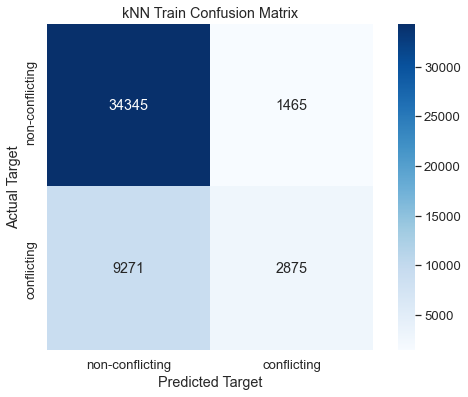

Best ROC Threshold=0.300000
saving image: Images/ROC_Train_kNN.png


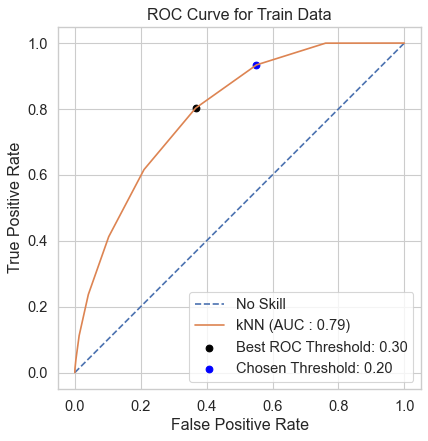

saving image: Images/PrecisionRecall_Test_kNN.png


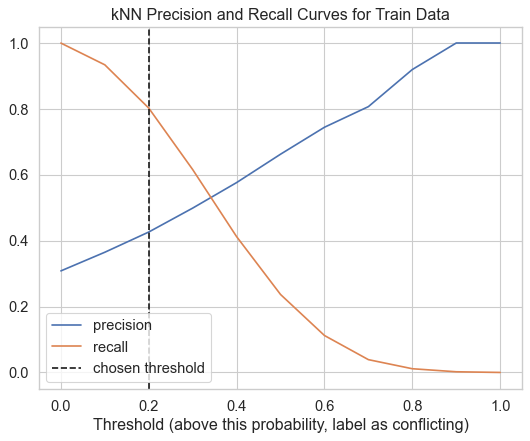

predicting on test set with a threshold of:  0.2
              precision    recall  f1-score   support

           0       0.84      0.59      0.69      8948
           1       0.36      0.68      0.47      3041

    accuracy                           0.61     11989
   macro avg       0.60      0.63      0.58     11989
weighted avg       0.72      0.61      0.64     11989

saving image: Images/ConfMat_kNN_Test.png


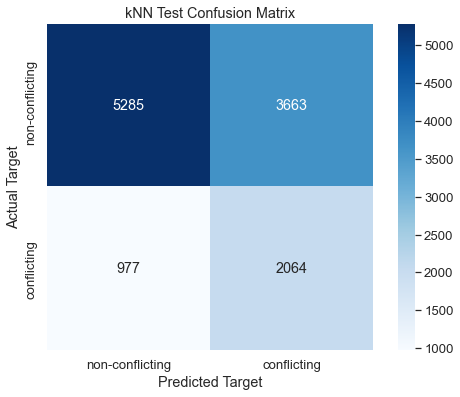

saving image: Images/ROC_Test_kNN.png


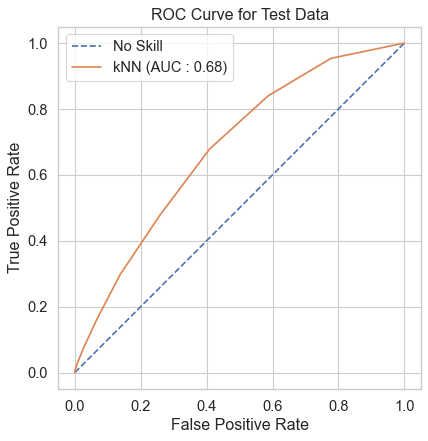

Current model is:  DecisionTree
Cross validation scores:
 [0.80082305 0.6788802  0.76121861 0.78180321 0.68423219]
              precision    recall  f1-score   support

           0       0.93      0.62      0.74     35810
           1       0.43      0.85      0.57     12146

    accuracy                           0.68     47956
   macro avg       0.68      0.73      0.66     47956
weighted avg       0.80      0.68      0.70     47956

saving image: Images/ConfMat_DecisionTree_Train.png


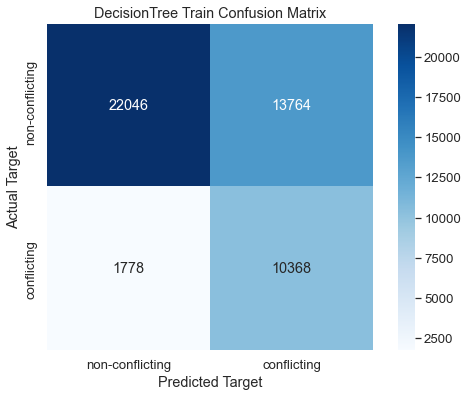

Best ROC Threshold=0.543230
saving image: Images/ROC_Train_DecisionTree.png


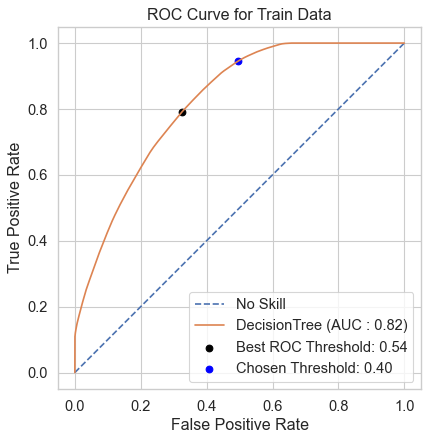

saving image: Images/PrecisionRecall_Test_DecisionTree.png


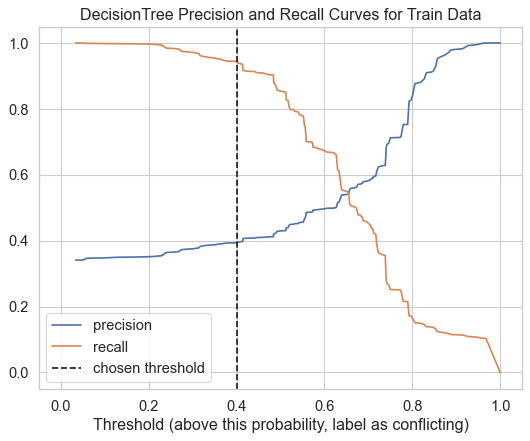

predicting on test set with a threshold of:  0.4
              precision    recall  f1-score   support

           0       0.90      0.48      0.62      8948
           1       0.35      0.85      0.50      3041

    accuracy                           0.57     11989
   macro avg       0.63      0.66      0.56     11989
weighted avg       0.76      0.57      0.59     11989

saving image: Images/ConfMat_DecisionTree_Test.png


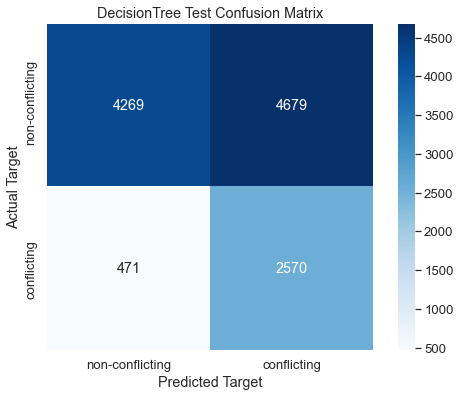

saving image: Images/ROC_Test_DecisionTree.png


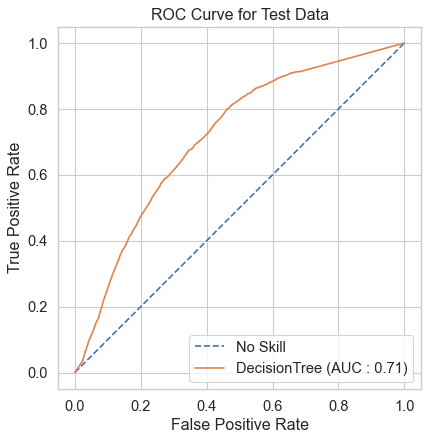

saving image: Images/FeatureImportance_DecisionTree.png


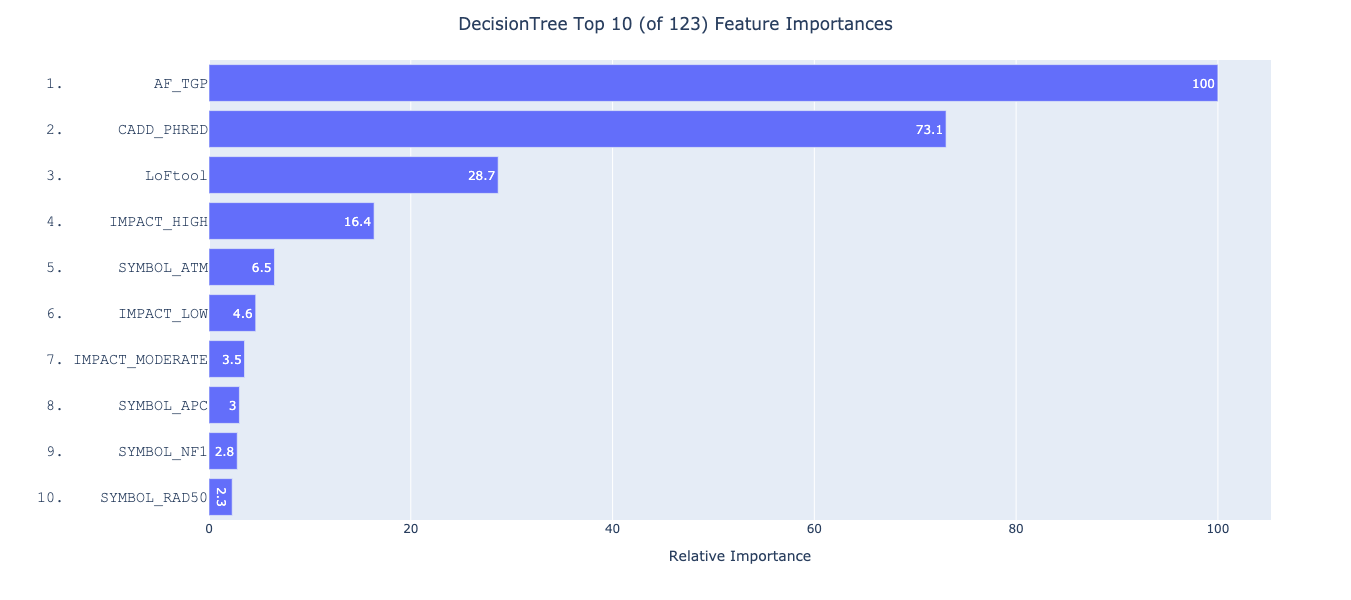

Current model is:  RandomForest
Cross validation scores:
 [0.60288066 0.56319473 0.57636888 0.59942363 0.61342116]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     35810
           1       0.59      0.88      0.71     12146

    accuracy                           0.81     47956
   macro avg       0.77      0.84      0.79     47956
weighted avg       0.86      0.81      0.82     47956

saving image: Images/ConfMat_RandomForest_Train.png


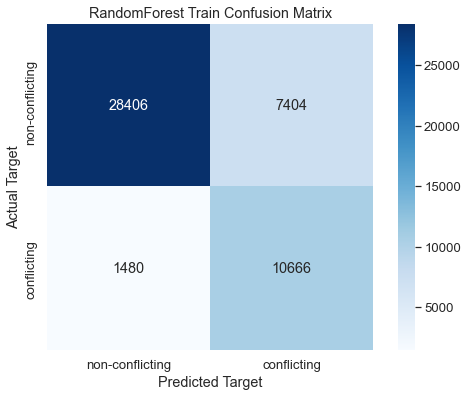

Best ROC Threshold=0.520721
saving image: Images/ROC_Train_RandomForest.png


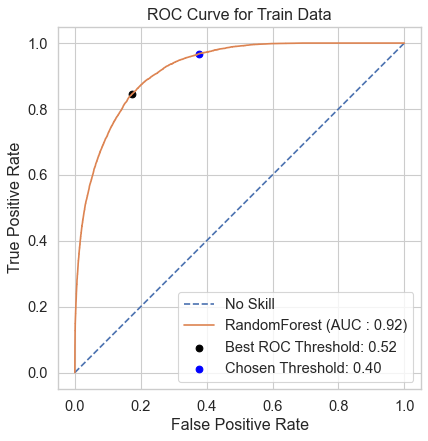

saving image: Images/PrecisionRecall_Test_RandomForest.png


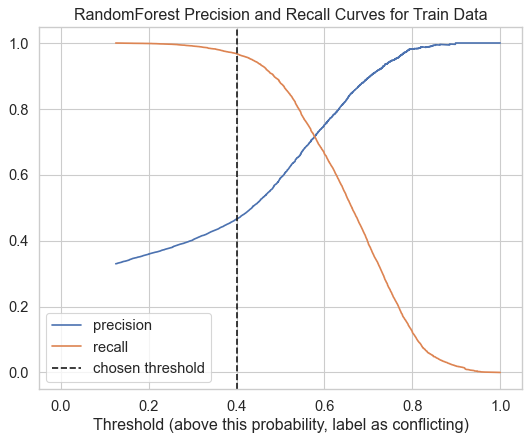

predicting on test set with a threshold of:  0.4
              precision    recall  f1-score   support

           0       0.88      0.55      0.68      8948
           1       0.37      0.79      0.51      3041

    accuracy                           0.61     11989
   macro avg       0.63      0.67      0.59     11989
weighted avg       0.75      0.61      0.63     11989

saving image: Images/ConfMat_RandomForest_Test.png


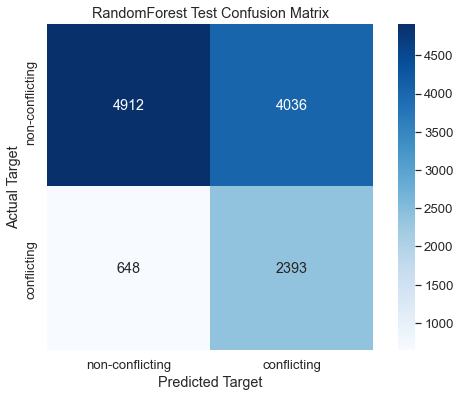

saving image: Images/ROC_Test_RandomForest.png


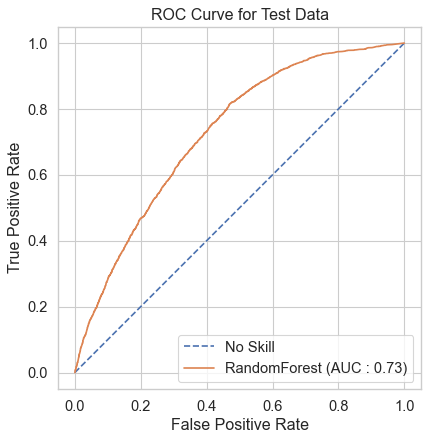

saving image: Images/FeatureImportance_RandomForest.png


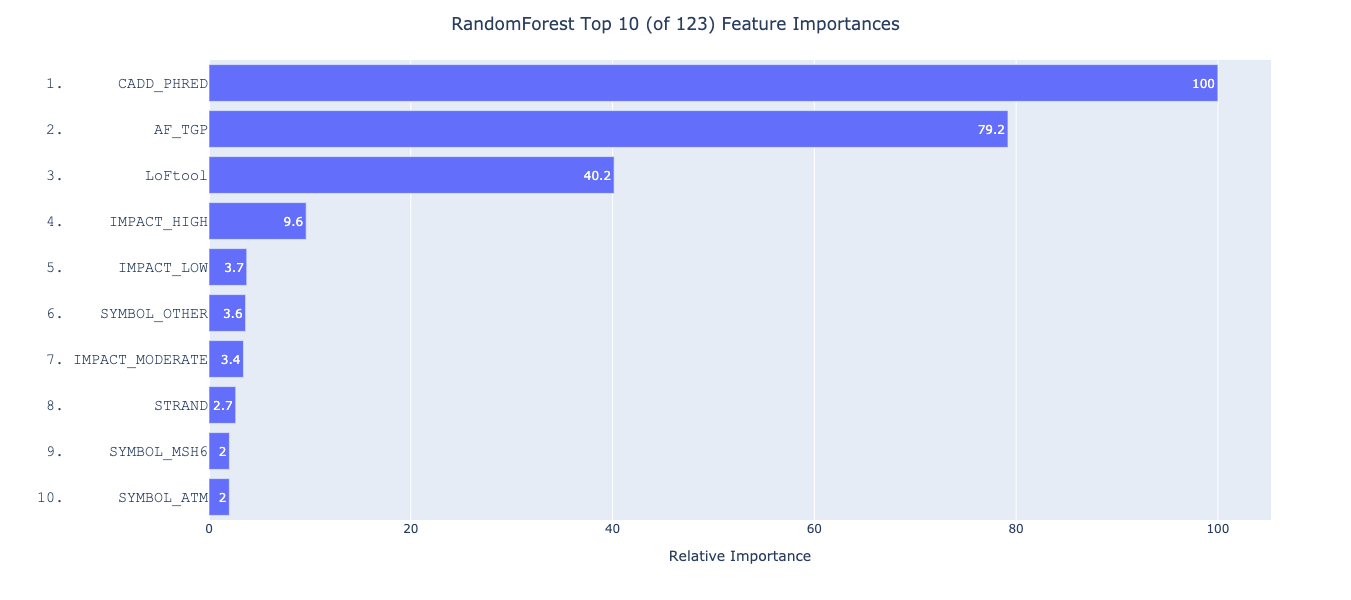

In [8]:
# fit models to train and test data, create plots

for i, thisModel in enumerate(models):
    model_name = model_names[i]
    print('Current model is: ', model_name)
    
    isTree = tree_check[i]
    
    if(isTree):
        this_pipeline = Pipeline(steps=[('tree_preprocessor', tree_preprocessor),
                                        ('classifier', eval(thisModel))])    
    else:
        this_pipeline = Pipeline(steps=[('this_preprocessor', kNN_preprocessor),
                                        ('classifier', eval(thisModel))])

    scores = cross_validate(this_pipeline, X_train, y_train,
                            scoring='recall',
                            return_estimator=True)
    
    print('Cross validation scores:\n', scores['test_score'])
    
    this_pipeline.fit(X_train, y_train)
    y_pred = this_pipeline.predict(X_train)
    meu.printMetricsAndConfMat(y_train, y_pred, model_name + " Train")
    
    if(isTree):
        chosenThreshold = 0.4
    else:
        chosenThreshold = 0.2
    
#     chosenThreshold = 
    meu.makeMetricPlots(this_pipeline, X_train, y_train, model_name, chosenThreshold)


    print('predicting on test set with a threshold of: ', chosenThreshold)
    
    y_test_pred = meu.adjusted_classes(this_pipeline.predict_proba(X_test)[:,1], chosenThreshold)
    
    meu.printMetricsAndConfMat(y_test, y_test_pred, model_name + " Test")
    _, roc_piece = meu.makeMetricPlots(this_pipeline, X_test, y_test, model_name, chosenThreshold, True)
    
    if(isTree):
        feature_importance = FeatureImportance(this_pipeline)
        filename = "Images/FeatureImportance_{}.png".format(model_name)
        print('saving image:', filename)
        feature_importance.plot(height=600, top_n_features=10, modelName=model_name, fileName=filename)
        
    roc_pieces.append(roc_piece)

saving image: Images/ROC_Comparison.png


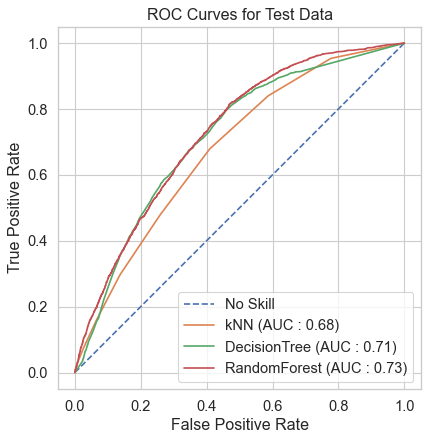

In [9]:
# compare ROC curves between different models
meu.makeCombinedROC(roc_pieces, model_names)